In [6]:
#.libPaths(c('/usr/share/R/library','/usr/lib64/R/library',''))
suppressMessages(library(SingleCellExperiment))
suppressMessages(library(scater))
options(stringsAsFactors = FALSE)
setwd("~/projects/training")

In [7]:
raw_mx <- read.table("05.matrix/hcc_lulab.sequentialMap.homer.merged.binned.filtered.mx", sep = "\t")
anno <- read.table("hcc_lulab.sample.info.txt", sep = "\t", header=T)
anno$Class <- "Ctrl"
anno[which(anno$Disease_status=="HCC_before_surgery"),"Class"] <- "HCC"
mx <- raw_mx[, (names(raw_mx) %in% anno$Sample_ID)]

****************
### construct singleCellExperiment object

In [8]:
reads <- SingleCellExperiment(
    assays = list(counts = as.matrix(mx)),
    colData = anno)

keep_feature <- rowSums(counts(reads) > 0) > 0
reads <- reads[keep_feature, ]
reads <- calculateQCMetrics(reads)

****************
### filter samples and genes

filter_by_total_counts
TRUE 
  45 

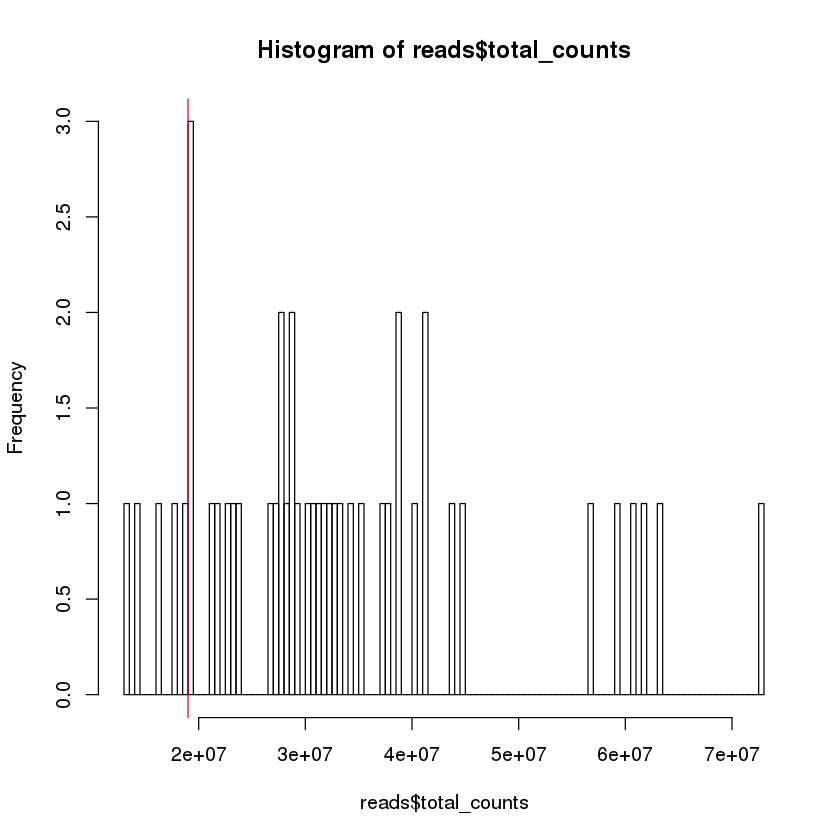

filter_by_expr_features
TRUE 
  45 

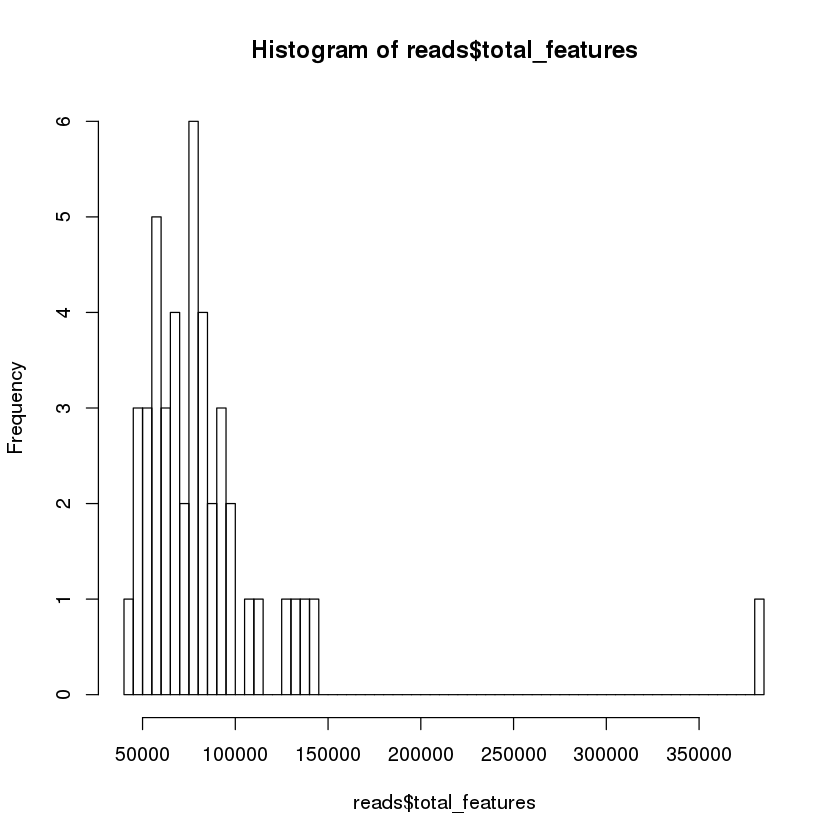

In [9]:
hist(reads$total_counts,breaks = 100)
abline(v=19000000, col="red")
filter_by_total_counts <- (reads$total_counts > 0)
table(filter_by_total_counts)

hist(reads$total_features,breaks = 100)
abline(v=15000, col="red")
filter_by_expr_features <- (reads$total_features > 0)
table(filter_by_expr_features)

In [ ]:
options(repr.plot.height=1)
options(repr.plot.width=1)

#### automitic filter

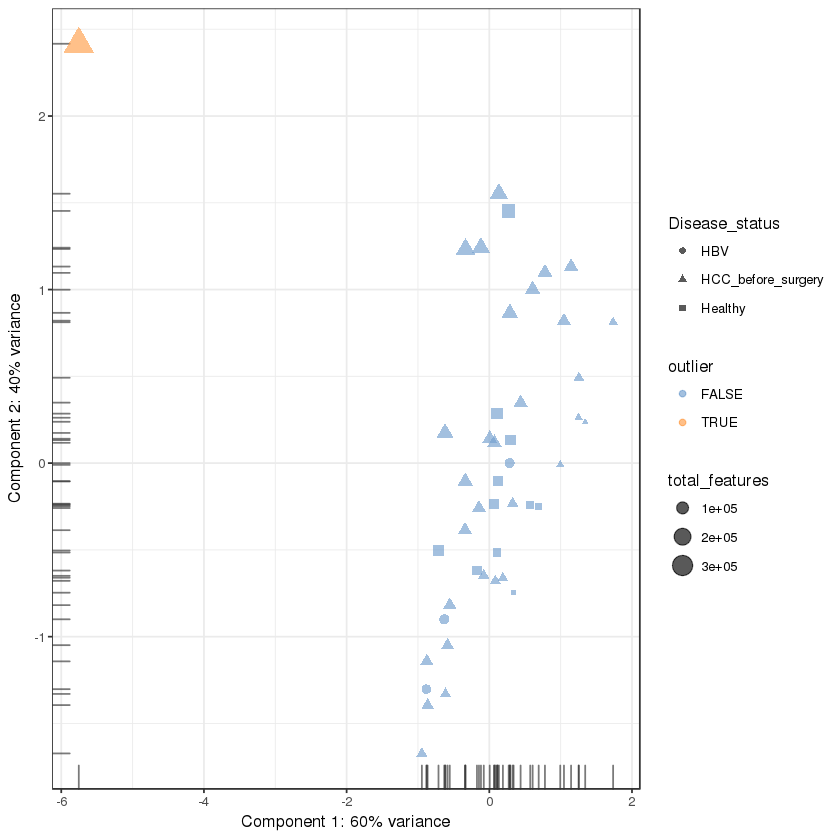

In [10]:
reads <- suppressMessages(plotPCA(
    reads,
    size_by = "total_features",
    shape_by = "Disease_status",
    pca_data_input = "pdata",
    detect_outliers = TRUE,
    return_SCE = TRUE
))

filter_by_outlier <- !reads$outlier

#### sample filtering

In [11]:
reads$use <- (
    # sufficient features (genes)
    filter_by_expr_features &
    # sufficient molecules counted
    filter_by_total_counts &
    # automatic filtering
    filter_by_outlier
)
table(reads$use)


FALSE  TRUE 
    1    44 

#### gene QC
##### filter genes with too low expression

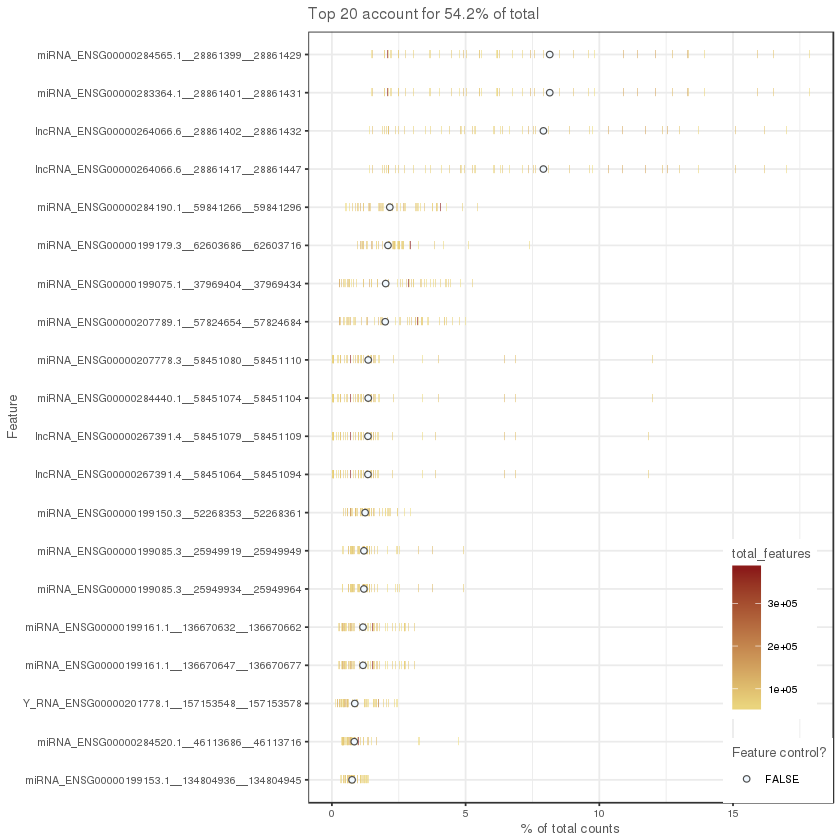

In [65]:
plotHighestExprs(reads,n=20)

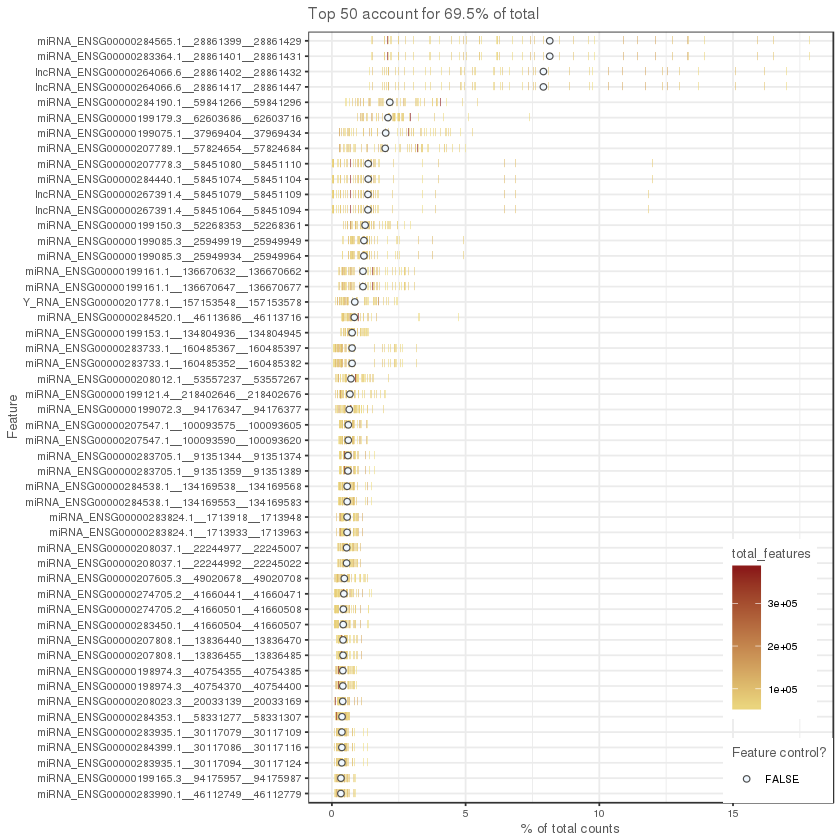

In [12]:
plotQC(reads, type = "highest-expression")

`geom_smooth()` using method = 'gam'


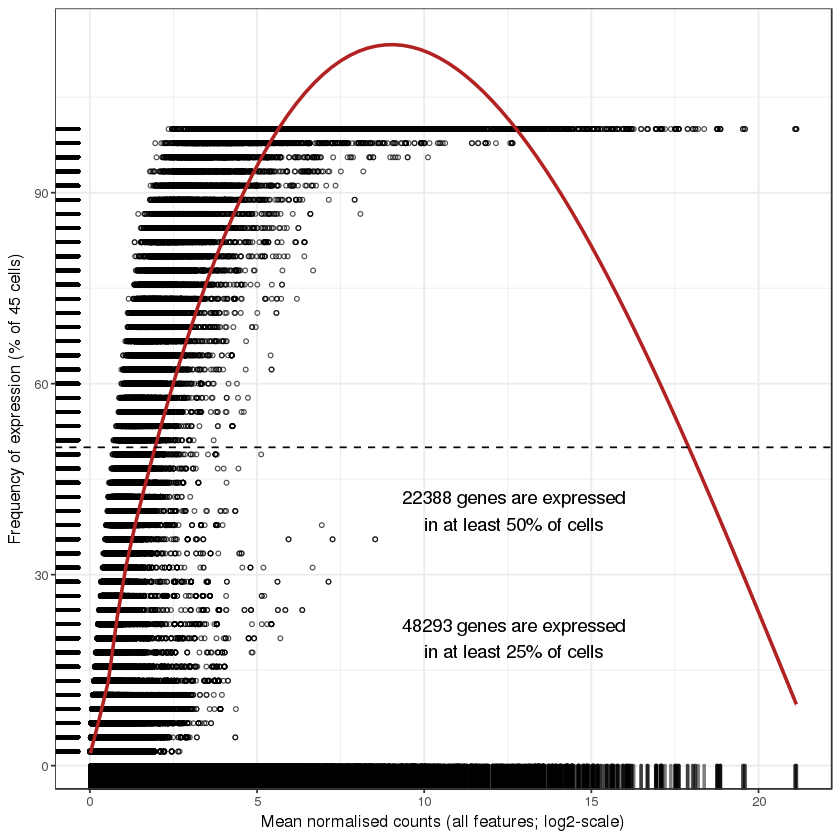

In [13]:
# top 20 
top20 <- c("Y_RNA_ENSG00000201778.1", "miRNA_ENSG00000284565.1", "miRNA_ENSG00000283364.1", "lncRNA_ENSG00000264066.6", "miRNA_ENSG00000284190.1", "miRNA_ENSG00000199179.3", "miRNA_ENSG00000199075.1", "miRNA_ENSG00000207789.1", "miRNA_ENSG00000284440.1", "miRNA_ENSG00000207778.3", "lncRNA_ENSG00000267391.4", "miRNA_ENSG00000199150.3", "miRNA_ENSG00000199161.1", "miRNA_ENSG00000199085.3", "miRNA_ENSG00000274705.2", "miRNA_ENSG00000283450.1", "miRNA_ENSG00000284520.1", "lncRNA_ENSG00000234741.7", "miRNA_ENSG00000199153.1", "miRNA_ENSG00000283733.1")

# number of cells with non-zero expression
plotQC(reads, type = "exprs-freq-vs-mean")

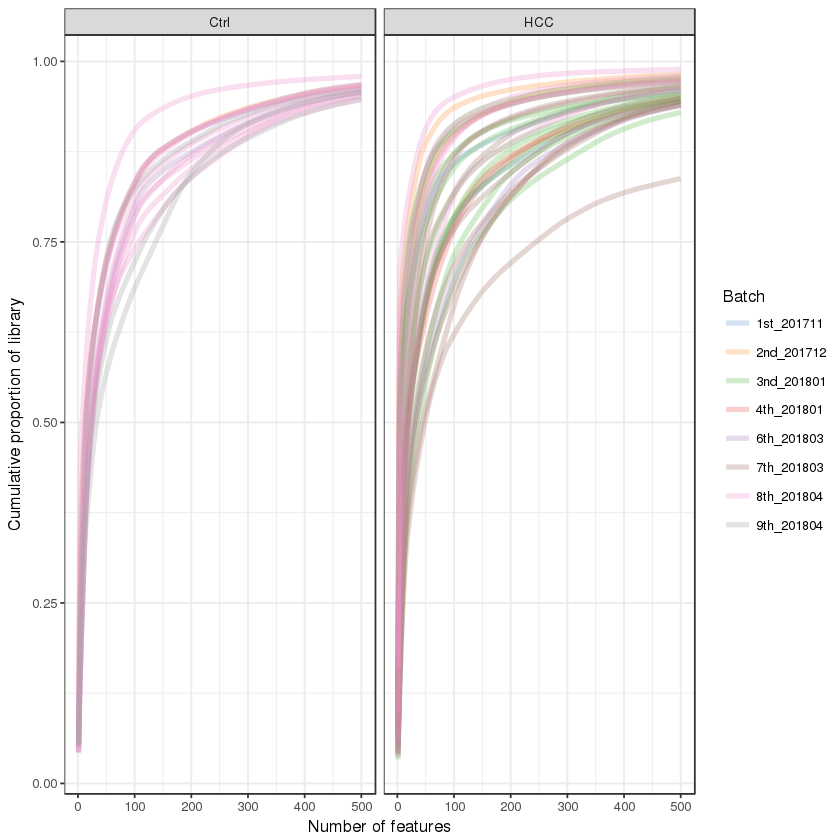

In [14]:
plotScater(reads, block1 = "Class",
     colour_by = "Batch", nfeatures = 500, exprs_values = "counts")

In [15]:
filter_genes <- apply(counts(reads[, colData(reads)$use]), 1, function(x) length(x[x >= 2]) >= 10)
table(filter_genes)
rowData(reads)$use <- filter_genes
reducedDim(reads) <- NULL
dim(reads[rowData(reads)$use, colData(reads)$use])

filter_genes
  FALSE    TRUE 
1562778   29325 

[1] 29325    44

In [16]:
assay(reads, "logcounts_raw") <- log2(counts(reads) + 1)
reads.qc <- reads[rowData(reads)$use, colData(reads)$use]
endog_genes <- !rowData(reads.qc)$is_feature_control

In [ ]:
# save the data
saveRDS(reads.qc, file = "05.matrix/hcc_lulab.sequentialMap.homer.merged.clean.binned.rds")
write.csv(counts(reads.qc), "05.matrix/hcc_lulab.sequentialMap.homer.merged.clean.binned.rds.csv")

## imputation

In [17]:
suppressMessages(library("scImpute"))
reads.qc <- readRDS("05.matrix/hcc_lulab.sequentialMap.homer.merged.clean.binned.rds")
sampleLables <- c()
for(i in colnames(reads.qc)){tmp <- as.character(anno[which(anno$Sample_ID==i),"Class"]); sampleLables <- c(sampleLables,tmp)}
scimpute(count_path = "hcc_lulab.sequentialMap.homer.merged.clean.binned.rds.csv", infile = "csv", outfile = "txt", out_dir = "./", Kcluster = 2, ncores = 2, labels = as.vector(sampleLables), labeled = TRUE)

[1] "reading in raw count matrix ..."
[1] "number of genes in raw count matrix 29325"
[1] "number of cells in raw count matrix 44"
[1] "estimating dropout probability for type 1 ..."
[1] "imputing dropout values for type 1 ..."
[1] "estimating dropout probability for type 2 ..."
[1] "imputing dropout values for type 2 ..."
[1] "writing imputed count matrix ..."


integer(0)

In [18]:
res.qc <- read.table("scimpute_count.txt")
reads.qc.impute <- SingleCellExperiment(assays = list(counts = as.matrix(res.qc)), colData = colData(reads.qc))
reads.qc.impute <- calculateQCMetrics(reads.qc.impute)
assay(reads.qc.impute, "logcounts_raw") <- log2(counts(reads.qc.impute) + 1)

**********************
## normalization

In [19]:
top20

[1] "Y_RNA_ENSG00000201778.1"  "miRNA_ENSG00000284565.1" 
 [3] "miRNA_ENSG00000283364.1"  "lncRNA_ENSG00000264066.6"
 [5] "miRNA_ENSG00000284190.1"  "miRNA_ENSG00000199179.3" 
 [7] "miRNA_ENSG00000199075.1"  "miRNA_ENSG00000207789.1" 
 [9] "miRNA_ENSG00000284440.1"  "miRNA_ENSG00000207778.3" 
[11] "lncRNA_ENSG00000267391.4" "miRNA_ENSG00000199150.3" 
[13] "miRNA_ENSG00000199161.1"  "miRNA_ENSG00000199085.3" 
[15] "miRNA_ENSG00000274705.2"  "miRNA_ENSG00000283450.1" 
[17] "miRNA_ENSG00000284520.1"  "lncRNA_ENSG00000234741.7"
[19] "miRNA_ENSG00000199153.1"  "miRNA_ENSG00000283733.1"

In [20]:
reads.qc.impute

class: SingleCellExperiment 
dim: 29325 44 
metadata(0):
assays(2): counts logcounts_raw
rownames(29325): miRNA_ENSG00000278851.1__65018535__65018565
  miRNA_ENSG00000283840.1__100277372__100277402 ...
  mRNA_ENSG00000283189.2__49422302__49422332
  mRNA_ENSG00000284395.1__1433327__1433357
rowData names(8): is_feature_control mean_counts ... total_counts
  log10_total_counts
colnames(44): lulab_17402567_B lulab_249136_B ... lulab_SH327412_B
  lulab_SH327428_B
colData names(15): Sample_ID Disease_status ...
  pct_counts_top_500_features is_cell_control
reducedDimNames(0):
spikeNames(0):

In [21]:
# log2 raw counts
plotExpression(reads.qc.impute, top20,
    colour_by = "Class", shape_by = "Disease_status",
    x = "Class", exprs_values="logcounts_raw")

ERROR: Error in exprs_mat[features, , drop = FALSE]: subscript out of bounds


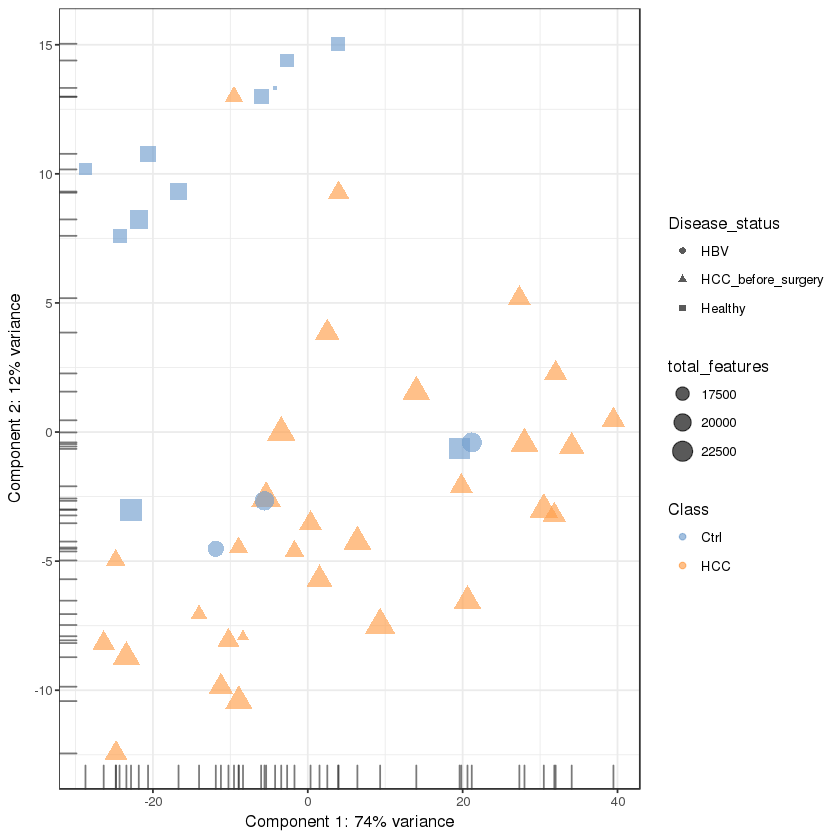

In [22]:
plotPCA(
    reads.qc.impute[endog_genes, ],
    exprs_values = "logcounts_raw",
    colour_by = "Class",
    shape_by = "Disease_status",
    size_by = "total_features"
)

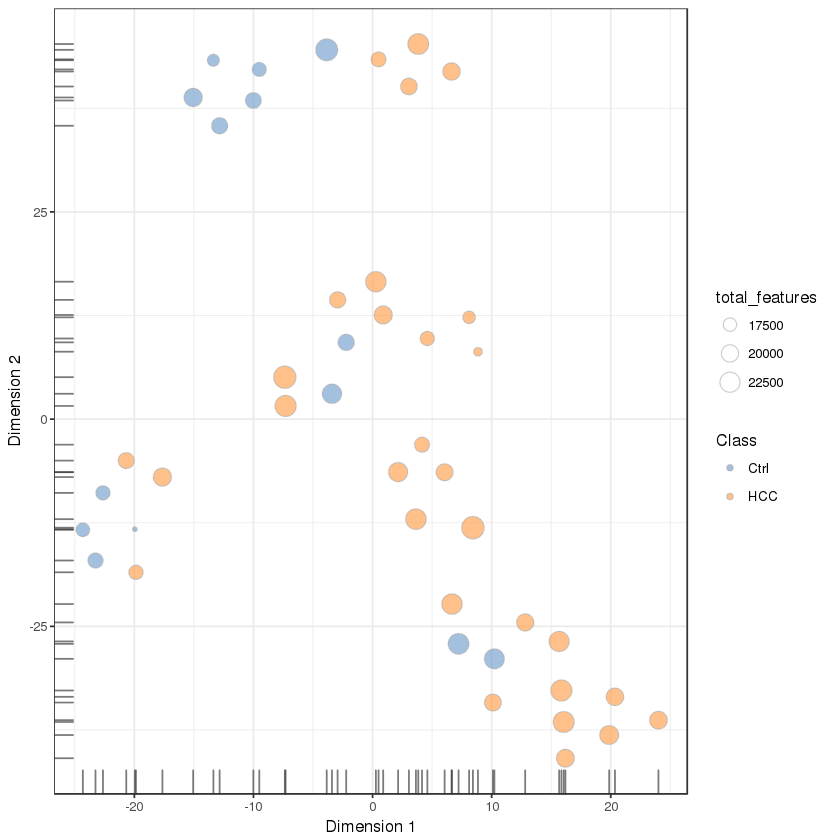

In [23]:
plotTSNE(
    reads.qc.impute[endog_genes, ],
    exprs_values = "logcounts_raw",
    perplexity = 8,
    colour_by = "Class",
    sharp_by = "Disease_status",
    size_by = "total_features",
    rand_seed = 123456,
    ntop = 300
)

In [24]:
# CPM
logcounts(reads.qc.impute) <- log2(calculateCPM(reads.qc.impute, use.size.factors = FALSE) + 1)

In [25]:
# scran (CPM)
library(scran)
# define cluster for each sample
sampleLables <- c()
for(i in colnames(reads.qc.impute)){tmp <- as.character(anno[which(anno$Sample_ID==i),"Class"]); sampleLables <- c(sampleLables,tmp)}
sampleLables <- replace(sampleLables, which(sampleLables=="HCC"),1)
sampleLables <- replace(sampleLables, which(sampleLables=="Ctrl"),2)
sampleLables <- as.numeric(sampleLables)

# sampleLables <- quickCluster(reads.qc.impute, min.size = 10)
reads.qc.impute <- computeSumFactors(reads.qc.impute, sizes = 5, clusters = sampleLables)
reads.qc.impute <- normalize(reads.qc.impute)

Loading required package: BiocParallel


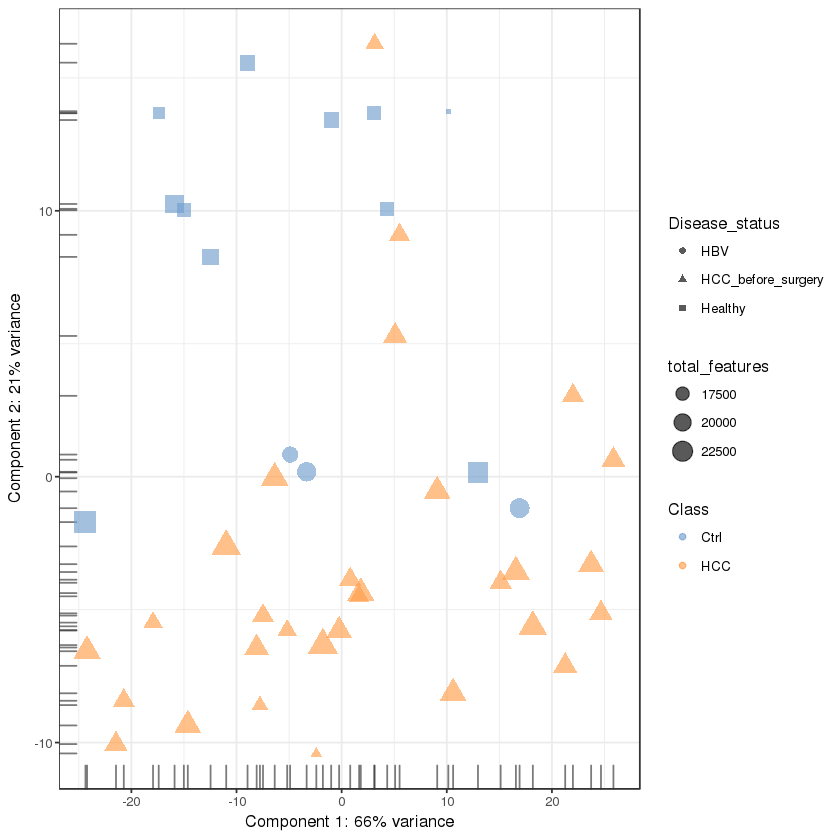

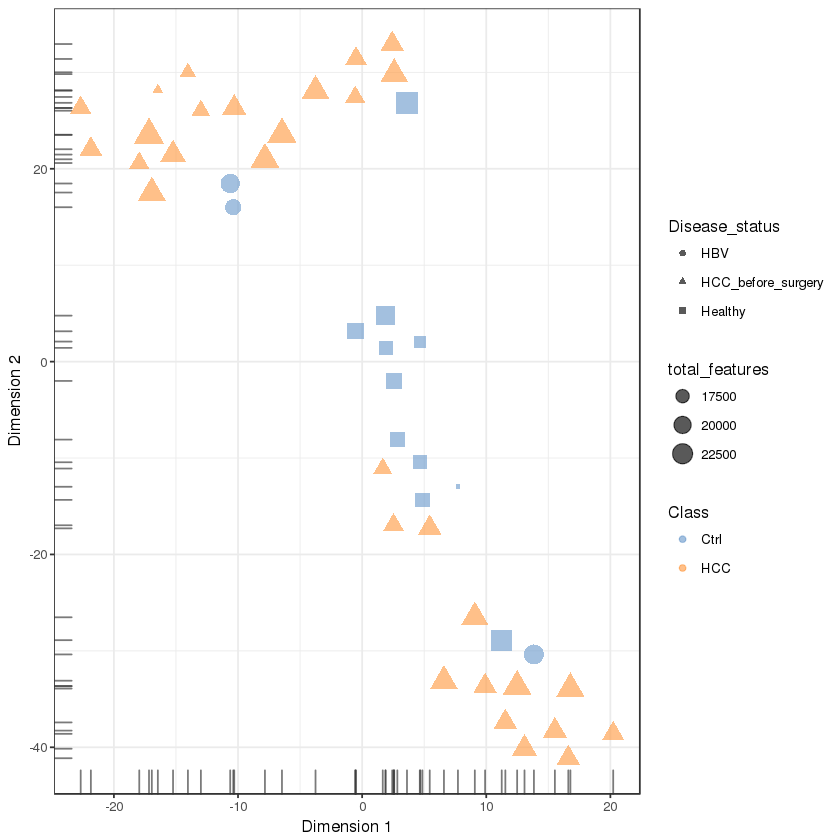

In [26]:
plotPCA(
    reads.qc.impute,
    exprs_values = "logcounts",
    colour_by = "Class",
    shape_by = "Disease_status",
    size_by = "total_features",
    ntop = 300
)

plotTSNE(
    reads.qc.impute,
    exprs_values = "logcounts",
    perplexity = 8,
    colour_by = "Class",
    shape_by = "Disease_status",
    size_by = "total_features",
    rand_seed = 123456,
    ntop = 300
)

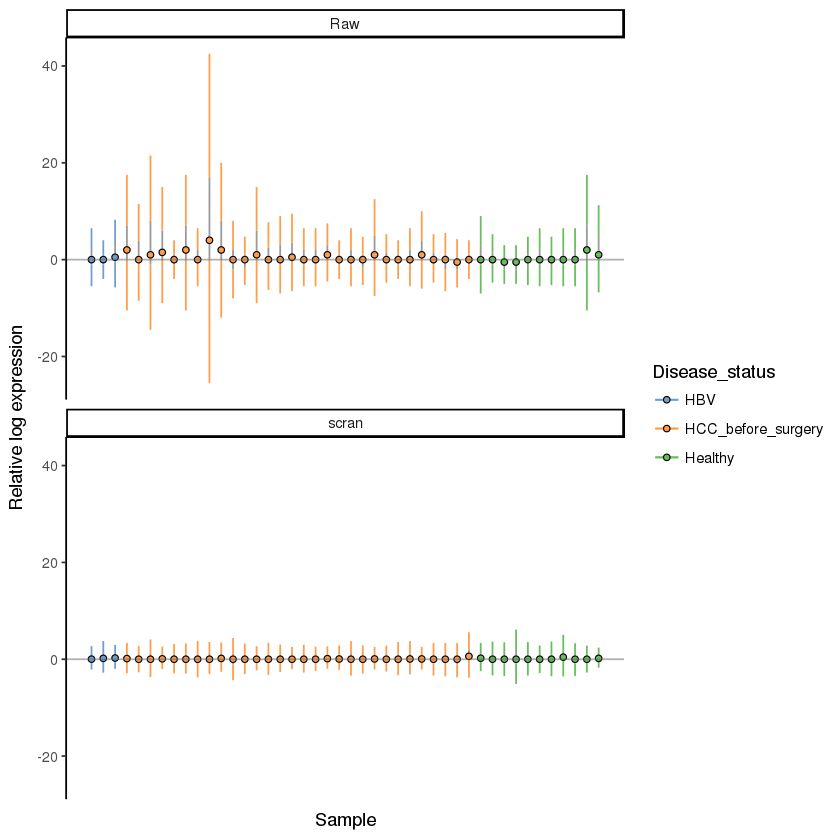

In [27]:
plotRLE(
    reads.qc.impute,
    exprs_mats = list(Raw = "counts", scran = "logcounts"),
    exprs_logged = c(TRUE, TRUE),
    colour_by = "Disease_status",
    legend = "auto"
)

***********************
## Dealing with confounders

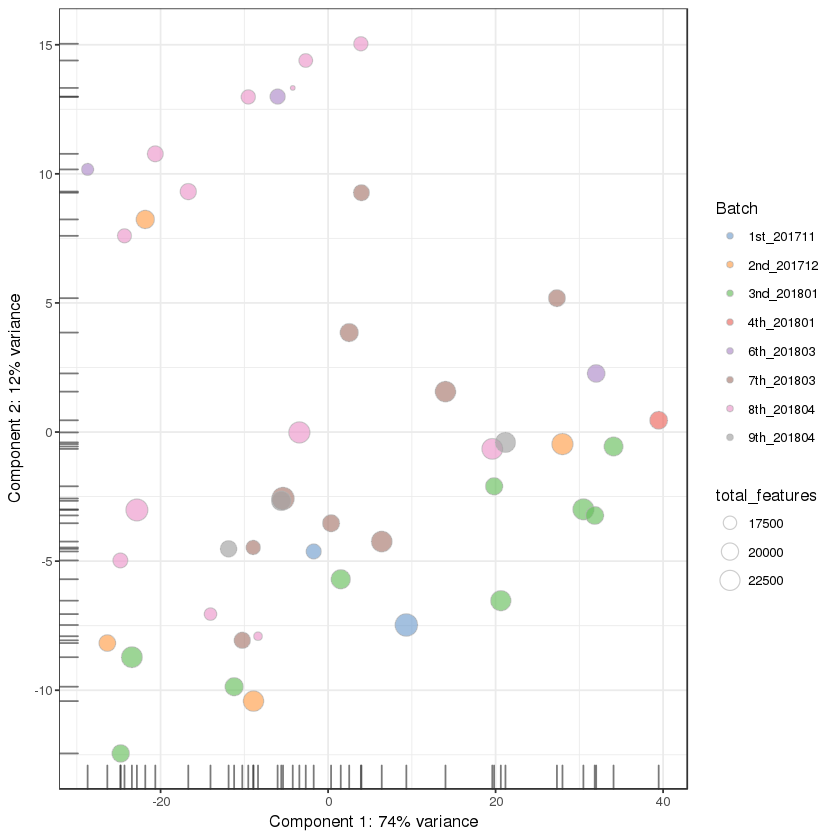

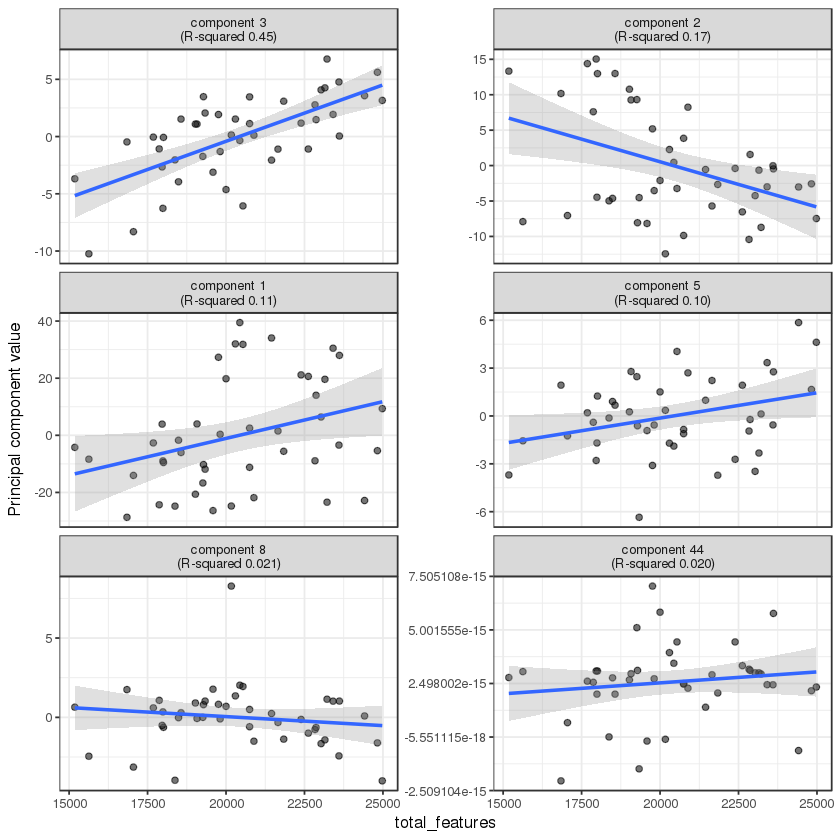

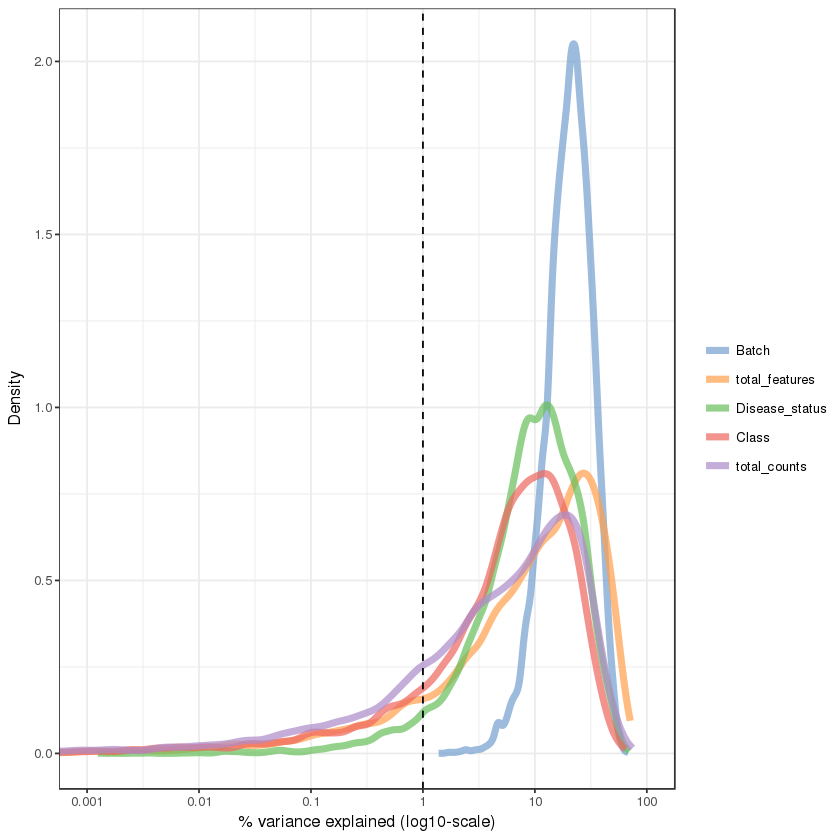

In [28]:
## check confounders
plotPCA(
    reads.qc.impute[endog_genes, ],
    exprs_values = "logcounts_raw",
    colour_by = "Batch",
    size_by = "total_features"
)
plotQC(
    reads.qc.impute[endog_genes, ],
    type = "find-pcs",
    exprs_values = "logcounts_raw",
    variable = "total_features"
)

plotQC(
    reads.qc.impute[endog_genes, ],
    type = "expl",
    exprs_values = "logcounts_raw",
    variables = c(
        "total_features",
        "total_counts",
        "Batch",
        "Disease_status",
        "Class"
    )
)

### remove batch effect using enfogenous genes

In [30]:
library(EDASeq)
library(RUVSeq)
library(sva)
library(scRNA.seq.funcs)

In [31]:
length(getLoadedDLLs())

[1] 106

####  using RUVseq (RUVs)

In [32]:
# RUVs uses centered (technical) replicate/negative control samples for which the covariates of interest are constant
scIdx <- matrix(-1, ncol = max(table(reads.qc.impute$Class)), nrow = 2)
tmp <- which(reads.qc.impute$Class == "HCC")
scIdx[1, 1:length(tmp)] <- tmp
tmp <- which(reads.qc.impute$Class == "Ctrl")
scIdx[2, 1:length(tmp)] <- tmp
cIdx <- rownames(reads.qc.impute)
ruvs <- RUVs(logcounts(reads.qc.impute), cIdx, k = 1, scIdx = scIdx, isLog = TRUE)
assay(reads.qc.impute, "ruvs1") <- ruvs$normalizedCounts
ruvs <- RUVs(logcounts(reads.qc.impute), cIdx, k = 5, scIdx = scIdx, isLog = TRUE)
assay(reads.qc.impute, "ruvs5") <- ruvs$normalizedCounts
ruvs <- RUVs(logcounts(reads.qc.impute), cIdx, k = 10, scIdx = scIdx, isLog = TRUE)
assay(reads.qc.impute, "ruvs10") <- ruvs$normalizedCounts
ruvs <- RUVs(logcounts(reads.qc.impute), cIdx, k = 20, scIdx = scIdx, isLog = TRUE)
assay(reads.qc.impute, "ruvs20") <- ruvs$normalizedCounts

In [33]:
library(edgeR)
countData <- counts(reads.qc.impute)
design <- read.table("hcc_lulab.sample.info.txt", sep = "\t", header=T)
design$Class <- "Ctrl"
design[which(design$Disease_status=="HCC_before_surgery"),"Class"] <- "HCC"
design <- design[design$Sample_ID %in% colnames(reads.qc.impute),]
colData <- design
design <-model.matrix(~Class, data=colData)

y <- DGEList(countData, samples=colData, group=colData$Class)
y <- calcNormFactors(y)
y <- estimateDisp(y, design)
fit <- glmFit(y, design)
lrt <- glmLRT(fit, coef=2)
top <- topTags(lrt, n=nrow(countData))$table
empirical <- rownames(countData)[which(!(rownames(countData) %in% rownames(top)[1:5000]))]


ruvg <- RUVg(logcounts(reads.qc.impute), empirical, k = 10, isLog = TRUE)
assay(reads.qc.impute, "ruvg10") <- ruvg$normalizedCounts
ruvg <- RUVg(logcounts(reads.qc.impute), empirical, k = 20, isLog = TRUE)
assay(reads.qc.impute, "ruvg20") <- ruvg$normalizedCounts


In [34]:
# using Combat
combat_data <- logcounts(reads.qc.impute)
mod_data <- as.data.frame(t(combat_data))
# Basic batch removal
mod0 = model.matrix(~ 1, data = mod_data) 
# Preserve biological variability
mod1 = model.matrix(~ reads.qc.impute$Class, data = mod_data) 
# adjust for total genes detected
mod2 = model.matrix(~ reads.qc.impute$total_features, data = mod_data)
assay(reads.qc.impute, "combat") <- ComBat(
    dat = t(mod_data), 
    batch = factor(reads.qc.impute$Batch), 
    mod = mod1,
    par.prior = TRUE,
    prior.plots = FALSE
)

Found8batches
Note: one batch has only one sample, setting mean.only=TRUE
Adjusting for1covariate(s) or covariate level(s)


Standardizing Data across genes


Fitting L/S model and finding priors
Finding parametric adjustments
Adjusting the Data



In [35]:
# using GLM
glm_fun <- function(g, batch, class) {
  model <- glm(g ~ batch + class)
  model$coef[1] <- 0 # replace intercept with 0 to preserve reference batch.
  return(model$coef)
}
effects <- apply(
    logcounts(reads.qc.impute), 
    1, 
    glm_fun, 
    batch = reads.qc.impute$Batch, 
    class = reads.qc.impute$Class
)
corrected <- logcounts(reads.qc.impute) - t(effects[as.numeric(factor(reads.qc.impute$Batch)), ])
assay(reads.qc.impute, "glm") <- corrected

In [36]:
# check PCA
pdf("reads.qc.impute.remove_confounders.binned.pca.pdf")
for(n in assayNames(reads.qc.impute)) {
    print(
        plotPCA(
            reads.qc.impute[endog_genes, ],
            colour_by = "Class",
            size_by = "total_features",
            shape_by = "Disease_status",
            exprs_values = n
        ) +
        ggtitle(n)
    )
}

In [37]:
# Effectiveness 1
pdf("reads.qc.impute.remove_confounders.binned.pca_Batch.pdf")
for(n in assayNames(reads.qc.impute)) {
    print(
        plotPCA(
            reads.qc.impute[endog_genes, ],
            colour_by = "Batch",
            size_by = "total_features",
            shape_by = "Class",
            exprs_values = n
        ) +
        ggtitle(n)
    )
}

In [38]:
# Effectiveness 2
pdf("reads.qc.impute.remove_confounders.binned.plotRLE.pdf")
res <- list()
for(n in assayNames(reads.qc.impute)) {
    res[[n]] <- suppressWarnings(calc_cell_RLE(assay(reads.qc.impute, n)))
}
par(mar=c(6,4,1,1))
boxplot(res, las=2)

In [39]:
pdf("reads.qc.impute.remove_confounders.binned.plotQC.pdf")
for(n in assayNames(reads.qc.impute)) {
    print(
        plotQC(
            reads.qc.impute[endog_genes, ],
            type = "expl",
            exprs_values = n,
            variables = c(
                "total_features",
                "total_counts",
                "Batch",
                "Class",
                "Disease_status"
            )
        ) +
        ggtitle(n)
    )
}

Warning message in self$trans$transform(x):
“NaNs produced”Warning message:
“Transformation introduced infinite values in continuous x-axis”Warning message:
“Removed 25 rows containing non-finite values (stat_density).”

### save data

In [47]:
saveRDS(reads.qc.impute, file = "05.matrix/hcc_lulab.sequentialMap.homer.merged.clean.impute.binned.rds")

************************
## Clustering

In [50]:
library(mclust)
library(SC3)
set.seed(1234567)

In [48]:
reads.qc.impute <- readRDS("05.matrix/hcc_lulab.sequentialMap.homer.merged.clean.impute.binned.rds")
#? hcc_lulab.sequentialMap.homer.merged.clean.impute.rds   ???

Estimating k...


[1] 2

ERROR: Error in sc3_prepare(object, gene_filter, pct_dropout_min, pct_dropout_max, : There is no `feature_symbol` column in the `rowData` slot of your dataset! Please write your gene/transcript names to `rowData(object)$feature_symbol`!


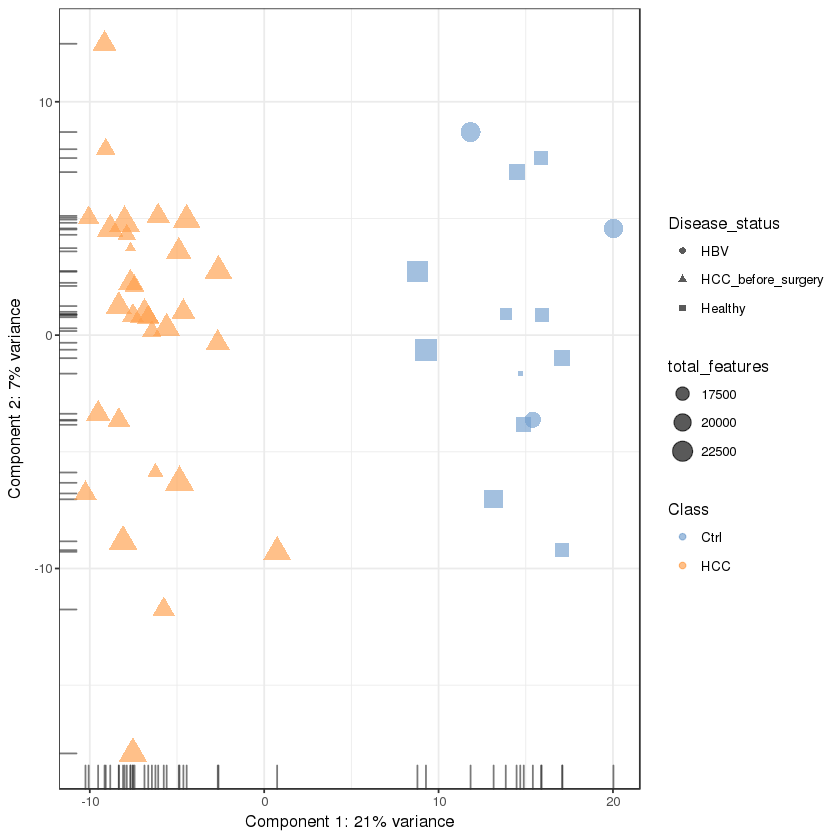

In [51]:
# using SC3
reads.qc.impute <- sc3_estimate_k(reads.qc.impute)
metadata(reads.qc.impute)$sc3$k_estimation
plotPCA(reads.qc.impute, exprs_values = "ruvs20", colour_by = "Class", size_by = "total_features", shape_by = "Disease_status")
# run sc3
reads.qc.impute <- sc3(reads.qc.impute, ks = 2, biology = TRUE)
# consensus matrix
sc3_plot_consensus(reads.qc.impute, k = 2, show_pdata = "Class")
# Silhouette plot
sc3_plot_silhouette(reads.qc.impute, k = 2)
# heatmap
sc3_plot_expression(reads.qc.impute, k = 2, show_pdata = "Class")
# identify marker genes
sc3_plot_markers(reads.qc.impute, k = 2, show_pdata = "Class")

****************
## feature selection

In [54]:
library(scRNA.seq.funcs)
library(matrixStats)
library(scran)
library(M3Drop)
library(RColorBrewer)
library(SingleCellExperiment)
set.seed(1)
library(RColorBrewer)

Loading required package: numDeriv


In [61]:
reads.qc.impute <- readRDS("hcc_lulab.sequentialMap.homer.merged.clean.impute.binned.rds")
anno <- read.table("hcc_lulab.sample.info.txt", sep = "\t", header=T)
anno$Class <- "Ctrl"
anno[which(anno$Disease_status=="HCC_before_surgery"),"Class"] <- "HCC"

sampleLables <- c()
for(i in colnames(reads.qc.impute)){tmp <- as.character(anno[which(anno$Sample_ID==i),"Class"]); sampleLables <- c(sampleLables,tmp)}

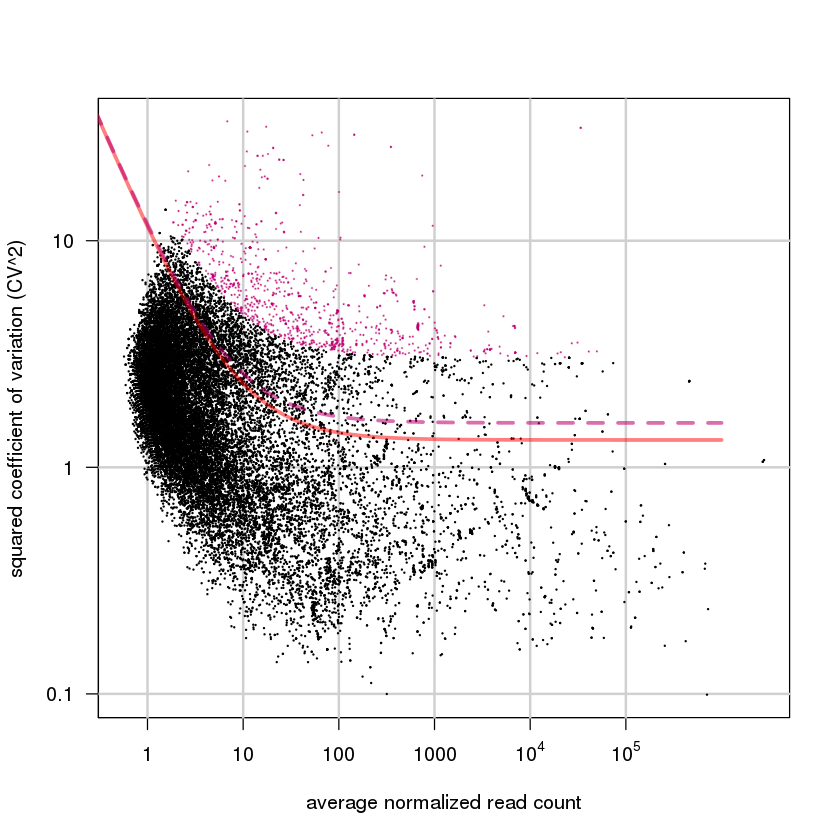

In [60]:
# highly variable genes without spike-ins
Brennecke_HVG <- BrenneckeGetVariableGenes(
    counts(reads.qc.impute),
    fdr = 0.05,
    minBiolDisp = 0.5
)

In [62]:
Brennecke_HVG

[1] "miRNA_ENSG00000207739.1__168768221__168768251"   
  [2] "miRNA_ENSG00000221081.1__140926172__140926202"   
  [3] "miRNA_ENSG00000221081.1__140926187__140926217"   
  [4] "miRNA_ENSG00000198973.4__219001645__219001675"   
  [5] "miRNA_ENSG00000207805.3__2134179__2134209"       
  [6] "miRNA_ENSG00000207925.1__53725442__53725472"     
  [7] "miRNA_ENSG00000207645.2__53666709__53666739"     
  [8] "miRNA_ENSG00000211520.2__56000759__56000789"     
  [9] "miRNA_ENSG00000284485.1__209432148__209432178"   
 [10] "miRNA_ENSG00000207644.1__53669187__53669217"     
 [11] "miRNA_ENSG00000266006.1__61508596__61508626"     
 [12] "miRNA_ENSG00000207734.1__53712313__53712343"     
 [13] "miRNA_ENSG00000207744.1__176150348__176150378"   
 [14] "miRNA_ENSG00000275816.1__51060063__51060093"     
 [15] "miRNA_ENSG00000283685.1__53751241__53751271"     
 [16] "miRNA_ENSG00000207967.1__116148605__116148635"   
 [17] "miRNA_ENSG00000207837.1__53721106__53721136"     
 [18] "miRNA_ENSG00000207571.1__54033995__54034025"     
 [19] "miRNA_ENSG00000283728.1__2434989__2435000"       
 [20] "miRNA_ENSG00000207705.2__128207872__128207902"   
 [21] "miRNA_ENSG00000216179.1__101064525__101064555"   
 [22] "miRNA_ENSG00000211520.2__56000729__56000759"     
 [23] "miRNA_ENSG00000207586.1__97563872__97563902"     
 [24] "miRNA_ENSG00000207798.1__55988980__55989010"     
 [25] "miRNA_ENSG00000199077.3__43581394__43581424"     
 [26] "miRNA_ENSG00000207645.2__53666724__53666754"     
 [27] "miRNA_ENSG00000284038.1__48579868__48579898"     
 [28] "miRNA_ENSG00000207938.1__17845137__17845167"     
 [29] "miRNA_ENSG00000221017.1__53671968__53671998"     
 [30] "miRNA_ENSG00000207548.3__55983042__55983072"     
 [31] "miRNA_ENSG00000207571.1__54033980__54034010"     
 [32] "miRNA_ENSG00000221563.1__66276869__66276899"     
 [33] "miRNA_ENSG00000207586.1__97563857__97563887"     
 [34] "miRNA_ENSG00000207938.1__17845152__17845182"     
 [35] "miRNA_ENSG00000199012.2__101065462__101065492"   
 [36] "miRNA_ENSG00000207594.1__53690911__53690941"     
 [37] "miRNA_ENSG00000207644.1__53669202__53669232"     
 [38] "miRNA_ENSG00000283685.1__53751256__53751286"     
 [39] "miRNA_ENSG00000221563.1__66276884__66276914"     
 [40] "miRNA_ENSG00000207739.1__168768206__168768236"   
 [41] "miRNA_ENSG00000199012.2__101065447__101065477"   
 [42] "miRNA_ENSG00000207692.3__127058148__127058178"   
 [43] "miRNA_ENSG00000207732.1__20528275__20528305"     
 [44] "miRNA_ENSG00000207734.1__53712298__53712328"     
 [45] "miRNA_ENSG00000215991.1__23418002__23418032"     
 [46] "miRNA_ENSG00000207711.1__53697533__53697563"     
 [47] "miRNA_ENSG00000207987.1__53729838__53729868"     
 [48] "miRNA_ENSG00000207590.1__220117928__220117958"   
 [49] "miRNA_ENSG00000207805.3__2134134__2134164"       
 [50] "miRNA_ENSG00000211997.1__79402037__79402067"     
 [51] "miRNA_ENSG00000211997.1__79402022__79402052"     
 [52] "miRNA_ENSG00000207548.3__55983027__55983057"     
 [53] "miRNA_ENSG00000283203.1__176601010__176601040"   
 [54] "miRNA_ENSG00000275816.1__51060048__51060078"     
 [55] "miRNA_ENSG00000221662.1__18897086__18897116"     
 [56] "miRNA_ENSG00000207548.3__55983012__55983042"     
 [57] "miRNA_ENSG00000207798.1__55988995__55989025"     
 [58] "miRNA_ENSG00000199095.1__53787905__53787935"     
 [59] "miRNA_ENSG00000215991.1__23418017__23418047"     
 [60] "miRNA_ENSG00000284038.1__48579883__48579913"     
 [61] "miRNA_ENSG00000211513.5__46709308__46709338"     
 [62] "miRNA_ENSG00000207594.1__53690881__53690911"     
 [63] "miRNA_ENSG00000207798.1__55989025__55989055"     
 [64] "miRNA_ENSG00000221662.1__18897071__18897101"     
 [65] "miRNA_ENSG00000207590.1__220117913__220117943"   
 [66] "miRNA_ENSG00000221421.1__53688481__53688511"     
 [67] "miRNA_ENSG00000284078.1__86620527__86620557"     
 [68] "miRNA_ENSG00000207935.3__70810005__70810035"     
 [69] "miRNA_ENSG00000216179.1__101064540__101064570"   
 [70] "miRNA_ENSG00000198973.4__219001660__219001690"   
 [71] "miRNA

In [59]:
HVG_genes <- Brennecke_HVG   #? $Gene